In [29]:
import sys
from os import path
from pathlib import Path

# from math import *


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy import stats as sp_stats

from sklearn import linear_model as sk_lm
from sklearn import model_selection as sk_ms

# import statsmodels.api as sm
# from sklearn.base import BaseEstimator, RegressorMixin
# import scipy.stats as scist
# from scipy.stats import rankdata


#from oneibl.one import ONE
from one.api import ONE
import brainbox.io.one as bbone
from brainbox.io.one import SpikeSortingLoader, EphysSessionLoader, SessionLoader
from brainbox.task.closed_loop import generate_pseudo_blocks
from brainbox.population.decode import get_spike_counts_in_bins

from iblutil.numerical import ismember
from iblutil.numerical import bincount2D

# from ibllib.atlas import AllenAtlas
from iblatlas.atlas import AllenAtlas

from brainwidemap import bwm_loading, bwm_units, bwm_query, load_good_units, \
    load_trials_and_mask, filter_sessions, download_aggregate_tables
from brainwidemap.receptive_fields.sta.regresssion_sta import load_passive_rf_map


In [2]:
######



one = ONE()
# one.refresh_cache('refresh')
ba = AllenAtlas()

NameError: name 'ONE' is not defined

In [1]:

# Specify a path to download the cluster and trials tables
# local_path = Path.home().joinpath('bwm_examples')
local_path = one.cache_dir.parent.joinpath('sta_cache')
local_path.mkdir(exist_ok=True)

NameError: name 'one' is not defined

In [32]:
# TODO: this should be seperated into prep (lag) and estimation to allow STA, GLM, etc estimators
def get_poisson_glm_sta(rfm, spikes, clusters, lag_sec=0, lag_bin=None):
    """
    This function estimates the receptive fields using poisson regression
    with cross-validated regularization and permutation tested p-value.

    You can specifify the lag between the frame time and evoked spike in
    frames or seconds.

    Args:
        rfm (AlfBunch): The passive receptive field mapping stimuli
        spikes (AlfBunch): The insertion spikes
        clusters (AlfBunc): The insertion clusters
        lag_sec (float): Lag between stimulus presentation and spike in sec
        lag_bin (int): lag between stimulus presewntation and spike in frame times
    """

    


In [33]:
bwm_df = bwm_query()

Loading bwm_query results from fixtures/2023_12_bwm_release.csv


In [34]:
bwm_df.columns

Index(['pid', 'eid', 'probe_name', 'session_number', 'date', 'subject', 'lab'], dtype='object')

In [35]:
# example session that contain VISp neurons

pid='799d899d-c398-4e81-abaf-1ef4b02d5475'
eid='e0928e11-2b86-4387-a203-80c77fab5d52'

# pid='29418b18-4db6-436f-a85e-b0f1d38d2e62'
# eid='fece187f-b47f-4870-a1d6-619afe942a7d'



In [36]:
visp_sessions = one.alyx.rest('sessions', 'list', task_protocol='ephys',
                          atlas_acronym='VISp')
visp_sessions_df = pd.DataFrame(visp_sessions)
visp_sessions_df = visp_sessions_df.rename(columns={"id": "eid"})

In [37]:
bwm_visp_sessions_df = pd.merge(bwm_df, visp_sessions_df, how='inner', on=['eid'])

In [38]:
# eid = bwm_visp_sessions_df.iloc[1].eid
# pid = bwm_visp_sessions_df.iloc[1].pid

In [39]:
rfm = load_passive_rf_map(eid, normalize=True, normalize_range=(-1,1), one=one)
spikes, clusters = load_good_units(one, pid, compute_metrics=False)

In [40]:
# test of function contents data preperation

# function parameters and defaults
# TODO: minimum spikes for estimatation? (speed benefit, lack of convergence problems)
# TODO: allow sec or bin? test for only one
lag=.08
# TODO: allow for space-time RF
prior_frames=1
glm_model = sk_lm.PoissonRegressor(fit_intercept=False)
# glm_model = sk_lm.Lasso(fit_intercept=False)
# glm_model = sk_lm.LassoCV(fit_intercept=True, n_alphas=25, cv=sk_ms.StratifiedKFold())  # LassoCV requires cv argument with stratified
glm_model_cv_hyper_param_dist = dict(alpha=sp_stats.gamma(a=1.05))
# glm_model_cv_hyper_param_dist = None

# function body
rfm_frame_rate = rfm['frame_rate']
rfm_frame_dwell_time = 1/rfm_frame_rate
rfm_frame_times = rfm['times']
# adjust frame times to be centered
rfm_frame_times = rfm_frame_times + (rfm_frame_dwell_time/2)
rfm_start_time = rfm_frame_times[0]
spike_times = spikes['times']
spike_clusters = spikes['clusters']
binned_spikes, binned_times, depths = bincount2D(spike_times, spike_clusters, rfm_frame_dwell_time, 0, None, None)
# adjust binned spike times to be centered
binned_spike_times = binned_times - (rfm_frame_dwell_time/2)
# get rfm spikes that follow a frame by lag
rfm_spike_time_ndx = np.nonzero(binned_spike_times > (rfm_start_time + lag))[0]
rfm_spike_time_ndx = rfm_spike_time_ndx[0:rfm_frame_times.shape[0]]
observed_spike_times = binned_spike_times[rfm_spike_time_ndx]
observed_spikes = binned_spikes[:,rfm_spike_time_ndx]
observed_pixels = rfm['frames']
observed_pixels = observed_pixels.reshape([observed_pixels.shape[0], -1])
# for each cluster with non-zero spike counts, get a cv optimized pglm fit
# TODO: output 'bunch'? Made of NP NDarrays?
# TODO: allow for space-time estimation?
estimated_rf = np.full((observed_pixels.shape[0],rfm['x_dim'],rfm['y_dim']), np.nan)
estimated_rf_alpha = np.full((observed_pixels.shape[0]), np.nan)
estimated_rf_null_dev = np.full((observed_pixels.shape[0]), np.nan)
estimated_rf_dev = np.full((observed_pixels.shape[0]), np.nan)
estimated_rf_p = np.full((observed_pixels.shape[0]), np.nan)
for cluster_ndx in np.nonzero(np.apply_along_axis(np.max, 1, observed_spikes)>0)[0]:
    # CV over hyperparameters, if required
    if glm_model_cv_hyper_param_dist is not None:
        # we will just a gamma dist for alpha, with a=1.05 for most density between 0 and 1
        glm_hyper_cv = sk_ms.RandomizedSearchCV(glm_model, glm_model_cv_hyper_param_dist, cv=sk_ms.StratifiedKFold(), n_iter=25) # StratifiedShuffleSplit fails if class has < 2 members
        # hyper_fit = cvpglm.fit(observed_pixels, observed_spikes[cluster_ndx,:])
        glm_hyper_fit = glm_hyper_cv.fit(observed_pixels, observed_spikes[cluster_ndx,:])
        glm_best_fit = glm_hyper_fit.best_estimator_
    else:
        glm_best_fit = glm_model.fit(observed_pixels, observed_spikes[cluster_ndx,:])
    glm_null = glm_hyper_fit.fit(np.ones((observed_pixels.shape[0],1)), observed_spikes[cluster_ndx,:])
    glm_best_fit_permute_p = sk_ms.permutation_test_score(glm_best_fit, observed_pixels, observed_spikes[cluster_ndx,:], n_permutations=50)
    estimated_rf_null_dev[cluster_ndx] = glm_null.score(np.ones((observed_pixels.shape[0],1)), observed_spikes[cluster_ndx,:])
    estimated_rf_dev[cluster_ndx] = glm_best_fit_permute_p[0]  # TODO: this is score, not always the same
    estimated_rf_alpha[cluster_ndx] = glm_best_fit.get_params()['alpha']  # TODO: need to get from dist dict or somewhere, fails for LassoCV
    # estimated_rf_alpha[cluster_ndx] = glm_best_fit.alpha_  # TODO: estimators with builtin cv store hyper elsewher, eg LassoCV
    estimated_rf[cluster_ndx,:,:] = glm_best_fit.coef_.reshape((rfm['x_dim'],rfm['y_dim']))
    estimated_rf_p[cluster_ndx] = glm_best_fit_permute_p[2]

/Users/dep/opt/miniforge3/envs/iblenv-x86/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/dep/opt/miniforge3/envs/iblenv-x86/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(
/Users/dep/opt/miniforge3/envs/iblenv-x86/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/Users/dep/opt/miniforge3/envs/iblenv-x86/lib/python3.10/site-packages/sklearn/model_selection/_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/Users/dep/opt/miniforge3/envs/iblenv-x86/lib/python3.10/site-packages/sklearn/_loss/link.py:174: RuntimeWarning

In [105]:
estimated_rf_null_dev.shape

IndexError: invalid index to scalar variable.

-1150.7552936813745

In [99]:
glm_best_fit.score(observed_pixels, observed_spikes[cluster_ndx,:])

-13.394960773215027

In [94]:
np.ones((observed_pixels.shape[0])).shape

(17999,)

(array([20.,  1.,  4.,  1.,  0.,  1.,  0.,  0.,  1.,  1.]),
 array([-0.62133912,  0.91572357,  2.45278625,  3.98984894,  5.52691162,
         7.06397431,  8.60103699, 10.13809968, 11.67516236, 13.21222505,
        14.74928773]),
 <BarContainer object of 10 artists>)

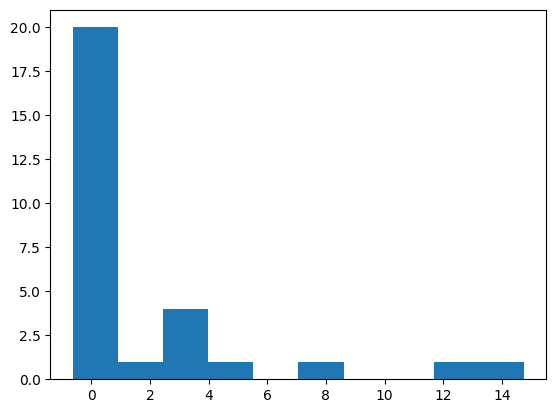

In [23]:
plt.hist(estimated_rf_dev-estimated_rf_null_dev)

In [41]:
np.nonzero(estimated_rf_dev>estimated_rf_null_dev)[0]

array([ 2,  3,  4,  5,  7,  9, 12, 14, 15, 17, 18, 21, 22, 23, 25, 26, 27,
       28, 29, 30, 31, 32, 33, 34])

In [42]:
np.nonzero(estimated_rf_p < 0.05)[0]

# estimated_rf[cluster_ndx]

array([1])

In [24]:
np.intersect1d(np.nonzero(estimated_rf_dev>estimated_rf_null_dev)[0], np.nonzero(estimated_rf_p < 0.05)[0])

array([], dtype=int64)

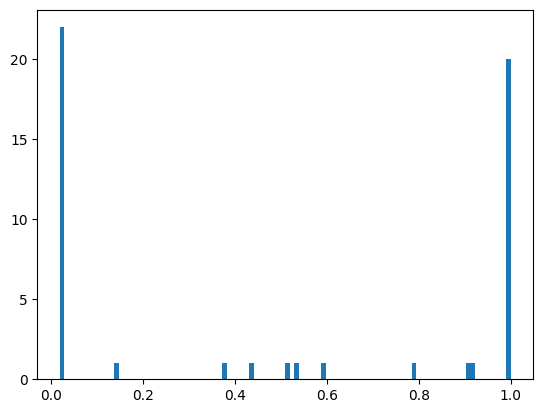

In [28]:
foo = plt.hist(estimated_rf_p,100,)

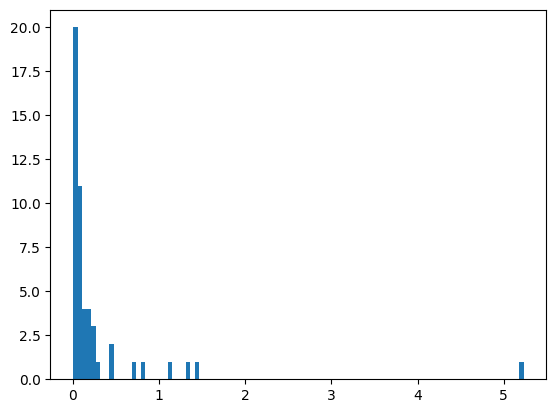

In [41]:
foo = plt.hist(estimated_rf_alpha, 100)

Alpha:  0.021374114260649762
perm p-val: 1.0


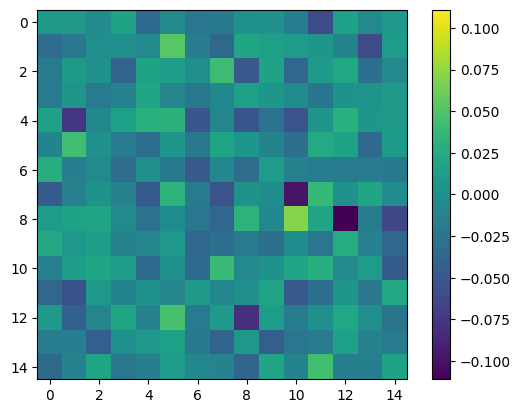

In [48]:
clust_id = 24
coef_range = np.max(np.abs(estimated_rf[clust_id,:,:])) 
plt.imshow(estimated_rf[clust_id,:,:], vmin=-coef_range, vmax=coef_range)
plt.colorbar()
print("Alpha: ", estimated_rf_alpha[clust_id])
print("perm p-val:", estimated_rf_p[clust_id])

0.013875178812117545

In [89]:
tmp.score(observed_pixels, observed_spikes[cluster_ndx,:])

0.00042397662191040464

In [21]:
print("Frame times (first 10): ", rfm_frame_times[0:10])
print("Spike times (first 10): ", observed_spike_times[0:10])


Frame times (first 10):  [3669.89984078 3669.91650744 3669.93317411 3669.94984078 3669.96650744
 3669.98317411 3669.99984078 3670.01650744 3670.03317411 3670.04984078]
Spike times (first 10):  [3669.90859658 3669.92526325 3669.94192992 3669.95859658 3669.97526325
 3669.99192992 3670.00859658 3670.02526325 3670.04192992 3670.05859658]


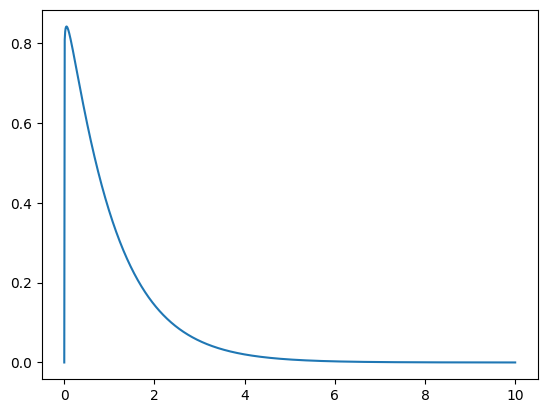

In [12]:
x = np.linspace(0,10,1000)
plt.plot(x, sp_stats.gamma.pdf(x, 1.05))

In [35]:
rf_clusters=np.unique(spike_clusters)
    
area_label=clusters['atlas_id'][rf_clusters].to_numpy()
    
beryl_label=ba.regions.remap(area_label, source_map='Allen', target_map='Beryl')
############ return cluster id ########################
QC_cluster_id=clusters['cluster_id'][rf_clusters].to_numpy()  

(array([1.5332e+04, 1.3480e+03, 6.3800e+02, 0.0000e+00, 3.4300e+02,
        2.0600e+02, 0.0000e+00, 8.8000e+01, 4.0000e+01, 3.0000e+00]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

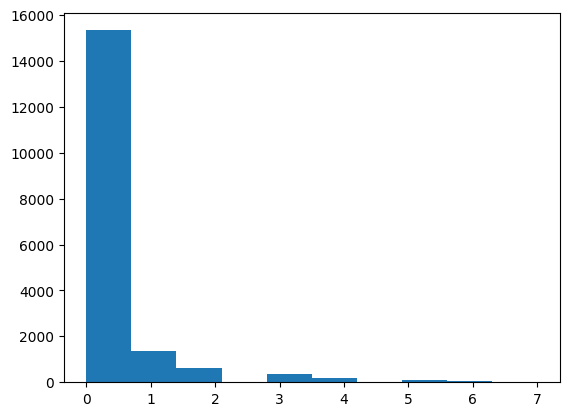

In [73]:
plt.hist(y.ravel())

(array([[208.,   0.,   0., ...,   0.,   0., 130.],
        [143.,   0.,   0., ...,   0.,   0., 104.],
        [247.,   0.,   0., ...,   0.,   0., 156.],
        ...,
        [156.,   0.,   0., ...,   0.,   0., 143.],
        [208.,   0.,   0., ...,   0.,   0., 234.],
        [208.,   0.,   0., ...,   0.,   0., 156.]]),
 array([-0.50196078, -0.40196078, -0.30196078, -0.20196078, -0.10196078,
        -0.00196078,  0.09803922,  0.19803922,  0.29803922,  0.39803922,
         0.49803922]),
 <a list of 225 BarContainer objects>)

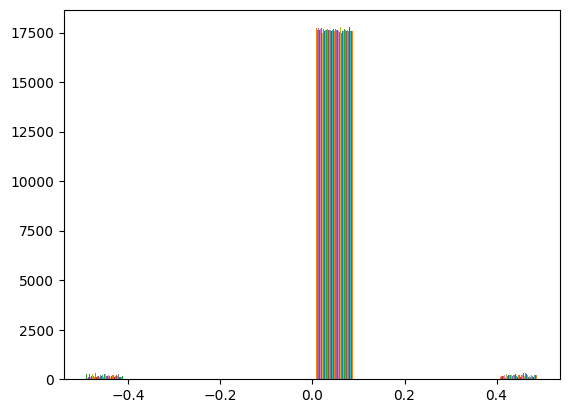

In [62]:
plt.hist(x[1:,:])

In [74]:
estimated_rf = sk_lm.PoissonRegressor(alpha=.001)
estimated_rf.fit(x[1:,:],y.ravel())

PoissonRegressor(alpha=0.001)

In [36]:
np.where(beryl_label==385)


(array([19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]),)

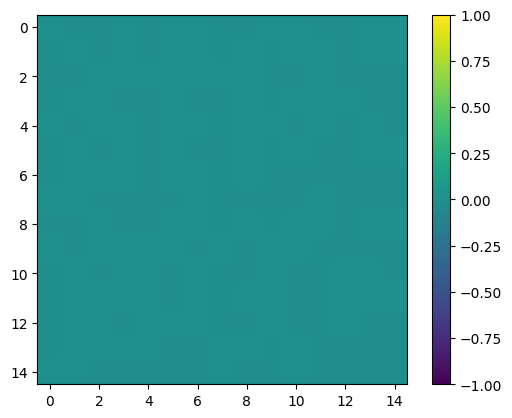

In [83]:
plt.imshow(estimated_rf[0].coef_.reshape(15,15), vmin=-1, vmax=1)
plt.colorbar()
# pglm.score(x[1:,:], y.ravel())

In [77]:

def pglm_dev(spk_cnt):
    y = spk_cnt
    x = rfm_frames.reshape((rfm_frames.shape[0],-1))
    pglm = sk_lm.PoissonRegressor(alpha=0.0001)
    pglm.fit(x[1:,:], y.ravel())
    return pglm.score(x[1:,:], y.ravel())

pglm_sta_devs = np.apply_along_axis(pglm_dev, 1, binned_array[:,binned_ndx+1])

/Users/dep/opt/miniforge3/envs/iblenv-x86/lib/python3.10/site-packages/sklearn/_loss/link.py:174: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/Users/dep/opt/miniforge3/envs/iblenv-x86/lib/python3.10/site-packages/sklearn/_loss/link.py:174: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/Users/dep/opt/miniforge3/envs/iblenv-x86/lib/python3.10/site-packages/sklearn/_loss/link.py:174: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/Users/dep/opt/miniforge3/envs/iblenv-x86/lib/python3.10/site-packages/sklearn/_loss/link.py:174: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/Users/dep/opt/miniforge3/envs/iblenv-x86/lib/python3.10/site-packages/sklearn/_loss/link.py:174: RuntimeWarning: divide by zero encountered in log
  return np.log(y_pred, out=out)
/Users/dep/opt/miniforge3/envs/iblenv-x86/lib/python3.10/site-packages/sklearn/_loss/link.py:17

nan
16


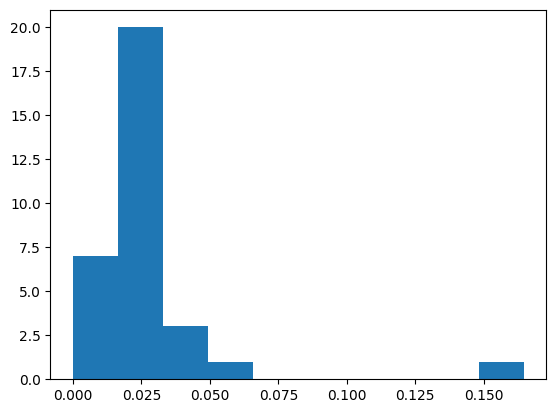

In [128]:
plt.hist(pglm_sta_devs)
print(pglm_sta_devs.max())
print(pglm_sta_devs.argmax())

In [10]:
ave_rf_sta, ave_rf_sta_on, ave_rf_sta_off, rf_sta, rf_sta_on, rf_sta_off, area_label, beryl_label, QC_cluster_id = compute_rf_sta_session(pid, eid)

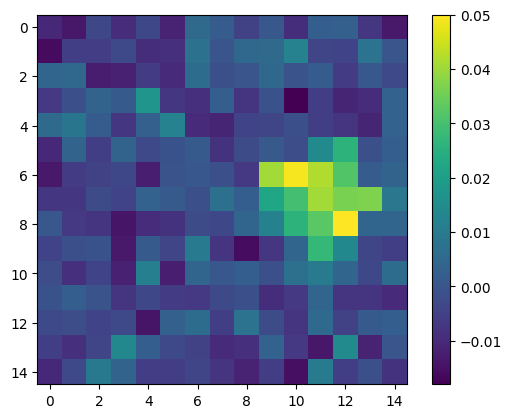

In [16]:
##### example receptive field (On + Off) ############
# cluster id=56   beryl_label= VISp
# time lag=3
z5=rf_sta[56,:,:,3]
fig=plt.imshow(z5-np.mean(z5))
plt.colorbar()

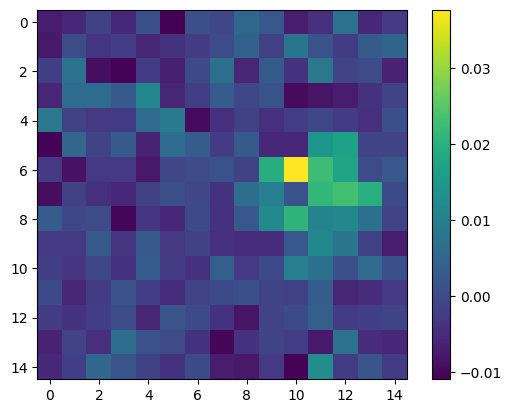

In [17]:
##### example receptive field (On) ############
# cluster id=56   beryl_label= VISp
# time lag=3
z5=rf_sta_on[56,:,:,3]
fig=plt.imshow(z5-np.mean(z5))
plt.colorbar()

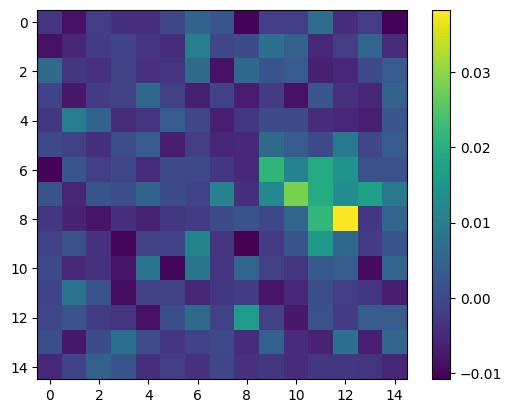

In [15]:
##### example receptive field (Off) ############
# cluster id=56   beryl_label= VISp
# time lag=3
z5=rf_sta_off[56,:,:,3]
fig=plt.imshow(z5-np.mean(z5))
plt.colorbar()

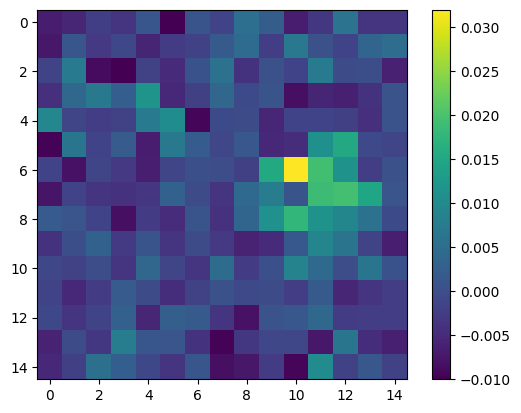

In [46]:
###### time-averaged RF ############

##### example receptive field (On + Off) ############
# cluster id=56   beryl_label= VISp
# time lag=3
z5=ave_rf_sta[56,:,:]
fig=plt.imshow(z5-np.mean(z5))
plt.colorbar()